# Establish a baseline Poisson Regression Model
- Use the International soccer database (ISDB) to predict the goals scored by each team.
- Database Description:
    - ISDBv2: 218,916 entries. 52 leagues, from 2000/01 to 2016/17 seasons
              completed leagues only.
    - ISDBv1: 216,743 entries. 52 leagues, from 2000/01 to 2017/18 seasons.
              Some leagues incomplete and some cover only subset of seasons.
- Metadata:
    - `'Date'`: Date on which the match took place.
    - `'Sea'` : Describes the yearly season in which the match happened.
    - `'Lea'` : League of in which the match is part of.
    - `'HT'`  : Home Team.
    - `'AT'`  : Away Team.
    - `'HS'`  : Goals scored by Home Team.
    - `'AS'`  : Goals scored by Away Team.
    - `'GD'`  : Goal difference (`HS - AS`)
    - `'WDL'` : Match outcome w/r to Home team (home win, home loss, draw)
- Use the poisson regressor of the GLM model in stats models
- Evaluate the model performance

In [10]:
import logging
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import helpers.hdbg as hdbg
import research_amp.soccer_prediction.models as rasoprmo
import research_amp.soccer_prediction.preproccesing as rasoprpr
import research_amp.soccer_prediction.utils as rasoprut

pd.set_option("display.max_columns", None)
warnings.filterwarnings("ignore")

In [2]:
_LOG = logging.getLogger(__name__)

In [3]:
def calculate_match_outcome_and_probabilities(
    df: pd.DataFrame,
    *,
    max_goals: int = 10,
    apply_dixon_coles: bool = False,
    rho: float = -0.2,
) -> pd.DataFrame:
    """
    Calculate match outcome probabilities for the entire DataFrame.

    :param df: Input DataFrame with predicted goals.
    :param max_goals: Maximum goals to consider for calculating the
        probabilities.
    :param apply_dixon_coles: Flag to apply Dixon-Coles adjustment.
    :param rho: Dixon-Coles adjustment parameter.
    :return: DataFrame with added probabilities for home win, away win,
        and draw.
    """
    hdbg.dassert_isinstance(df, pd.DataFrame)
    # Calculate Poisson probabilities for Home team goals.
    home_goals_probs = np.array(
        [
            np.exp(-df["Lambda_HS"]) * df["Lambda_HS"] ** i / np.math.factorial(i)
            for i in range(max_goals)
        ]
    )
    # Calculate Poisson probabilities for Away team goals.
    away_goals_probs = np.array(
        [
            np.exp(-df["Lambda_AS"]) * df["Lambda_AS"] ** i / np.math.factorial(i)
            for i in range(max_goals)
        ]
    )
    # Initialize probabilities.
    prob_home_win = np.zeros(len(df))
    prob_away_win = np.zeros(len(df))
    prob_draw = np.zeros(len(df))
    # Calculate the probabilities of home win, away win, and draw.
    for i in range(max_goals):
        for j in range(max_goals):
            prob = home_goals_probs[i] * away_goals_probs[j]
            if apply_dixon_coles:
                prob *= dixon_coles_adjustment(
                    i, j, df["Lambda_HS"], df["Lambda_AS"], rho
                )
            prob_home_win += np.where(i > j, prob, 0)
            prob_away_win += np.where(i < j, prob, 0)
            prob_draw += np.where(i == j, prob, 0)
    # Add probabilities to the DataFrame.
    df["prob_home_win"] = prob_home_win
    df["prob_away_win"] = prob_away_win
    df["prob_draw"] = prob_draw
    # Predict the outcomes based on probabilities.
    df["predicted_outcome"] = np.where(
        df["prob_home_win"] > df["prob_away_win"],
        "home_win",
        np.where(df["prob_away_win"] > df["prob_home_win"], "away_win", "draw"),
    )
    # Calculate actual outcomes for comparison.
    df["actual_outcome"] = np.where(
        df["HS"] > df["AS"],
        "home_win",
        np.where(df["HS"] < df["AS"], "away_win", "draw"),
    )
    # Round off the predicted goals to integers.
    df["Lambda_HS"] = df["Lambda_HS"].round().astype(int)
    df["Lambda_AS"] = df["Lambda_AS"].round().astype(int)
    print(df.head())
    return df


def poisson_model(label_encode: bool = False):
    # Define the S3 Buckets, dataset path and local directory for download.
    bucket = "cryptokaizen-data-test"
    dataset_path = "kaizen_ai/soccer_prediction/datasets/OSF_football/"
    local_dir = "datasets/OSF_football"
    # Download data from S3.
    rasoprut.download_data_from_s3(
        bucket_name=bucket, dataset_path=dataset_path, local_path=local_dir
    )
    # Load the data from S3 into pandas dataframe objects.
    dataframes = rasoprut.load_data_to_dataframe(local_path=local_dir)
    # Access the dataframes directly from the dictionary.
    dataframes.get("ISDBv1_df")
    ISDBv2_df = dataframes.get("ISDBv2_df")
    rasoprut.compute_stats(ISDBv2_df)
    # Preprocess and unravel data.
    preprocessed_df, pipeline = rasoprpr.preprocess_and_unravel_data(
        ISDBv2_df, add_epsilon_flag=True
    )
    train_df = preprocessed_df.get("train_df")
    test_df = preprocessed_df.get("test_df")
    # Train model
    hyperparameters = {
        "formula": "goals~ team + opponent + is_home",
        "maxiter": 10,
    }
    sample_sizes = [20000, 30000, 40000, 50000, 60000]
    columns = ["team", "opponent", "goals", "is_home"]
    poisson_model = rasoprmo.PoissonModel()
    trained_model = rasoprmo.train_model(
        train_df[columns],
        poisson_model,
        hyperparameters,
        sample_sizes=sample_sizes,
    )
    # Generate predictions.
    test_df["predicted_goals"] = trained_model.predict(
        test_df[["team", "opponent", "is_home"]]
    )
    # Recombine predictions.
    final_df = rasoprut.recombine_predictions(test_df)
    # Calculate match outcome probabilities.
    final_df = calculate_match_outcome_and_probabilities(final_df)
    # Evaluate model.
    rasoprut.evaluate_model_predictions(
        final_df["actual_outcome"], final_df["predicted_outcome"]
    )
    # Inverse transform.
    if label_encode:
        pipeline.named_steps["label_encoding"].inverse_transform(final_df)
    # Save data to S3.
    s3_path_predictions = "kaizen_ai/soccer_prediction/model_output/glm_poisson"
    rasoprut.save_data_to_s3(
        df=final_df,
        bucket_name=bucket,
        s3_path=s3_path_predictions,
        file_name="glm_poisson_predictions",
    )

INFO:research_amp.soccer_prediction.utils:Downloading kaizen_ai/soccer_prediction/datasets/OSF_football/ISDBv1.txt to datasets/OSF_football/ISDBv1.txt
INFO:research_amp.soccer_prediction.utils:Downloading kaizen_ai/soccer_prediction/datasets/OSF_football/ISDBv2.txt to datasets/OSF_football/ISDBv2.txt
INFO:research_amp.soccer_prediction.utils:Data Downloaded.
INFO:research_amp.soccer_prediction.utils:Loading datasets/OSF_football/ISDBv1.txt
INFO:research_amp.soccer_prediction.utils: ISDBv1_df,  (216743, 9)
INFO:research_amp.soccer_prediction.utils:Loading datasets/OSF_football/ISDBv2.txt
INFO:research_amp.soccer_prediction.utils: ISDBv2_df,  (218916, 9)
INFO:research_amp.soccer_prediction.utils:Data loaded into dataframes.
INFO:research_amp.soccer_prediction.utils:Value Counts:
WDL
W    99459
L    60188
D    59269
INFO:research_amp.soccer_prediction.preproccesing:Rows removed after the operation: 0 
INFO:research_amp.soccer_prediction.preproccesing:Column 'HS' had 28650 rows affected.
I

INFO:root:Sample Size: 20000.000000, Train MAE: 0.885605, Validation MAE: 0.956635
INFO:research_amp.soccer_prediction.models:Poisson model fitted successfully.
INFO:research_amp.soccer_prediction.models:                 Generalized Linear Model Regression Results                  
Dep. Variable:                  goals   No. Observations:                24000
Model:                            GLM   Df Residuals:                    22745
Model Family:                 Poisson   Df Model:                         1254
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -32567.
Date:                Tue, 02 Jul 2024   Deviance:                       13718.
Time:                        15:06:20   Pearson chi2:                 1.53e+04
No. Iterations:                    10   Pseudo R-squ. (CS):            0.07807
Covariance Type:            nonrobust                                         
      

INFO:root:Sample Size: 30000.000000, Train MAE: 0.905732, Validation MAE: 0.942181
INFO:research_amp.soccer_prediction.models:Poisson model fitted successfully.
INFO:research_amp.soccer_prediction.models:                 Generalized Linear Model Regression Results                  
Dep. Variable:                  goals   No. Observations:                32000
Model:                            GLM   Df Residuals:                    30740
Model Family:                 Poisson   Df Model:                         1259
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -43505.
Date:                Tue, 02 Jul 2024   Deviance:                       18549.
Time:                        15:07:19   Pearson chi2:                 2.08e+04
No. Iterations:                     5   Pseudo R-squ. (CS):            0.06870
Covariance Type:            nonrobust                                         
      

INFO:root:Sample Size: 40000.000000, Train MAE: 0.912811, Validation MAE: 0.946903
INFO:research_amp.soccer_prediction.models:Poisson model fitted successfully.
INFO:research_amp.soccer_prediction.models:                 Generalized Linear Model Regression Results                  
Dep. Variable:                  goals   No. Observations:                40000
Model:                            GLM   Df Residuals:                    38740
Model Family:                 Poisson   Df Model:                         1259
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -54517.
Date:                Tue, 02 Jul 2024   Deviance:                       23451.
Time:                        15:09:13   Pearson chi2:                 2.64e+04
No. Iterations:                    10   Pseudo R-squ. (CS):            0.06314
Covariance Type:            nonrobust                                         
      

INFO:root:Sample Size: 50000.000000, Train MAE: 0.917394, Validation MAE: 0.941100
INFO:research_amp.soccer_prediction.models:Poisson model fitted successfully.
INFO:research_amp.soccer_prediction.models:                 Generalized Linear Model Regression Results                  
Dep. Variable:                  goals   No. Observations:                48000
Model:                            GLM   Df Residuals:                    46738
Model Family:                 Poisson   Df Model:                         1261
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -65401.
Date:                Tue, 02 Jul 2024   Deviance:                       28188.
Time:                        15:10:42   Pearson chi2:                 3.18e+04
No. Iterations:                     5   Pseudo R-squ. (CS):            0.06152
Covariance Type:            nonrobust                                         
      

INFO:root:Sample Size: 60000.000000, Train MAE: 0.917014, Validation MAE: 0.941408


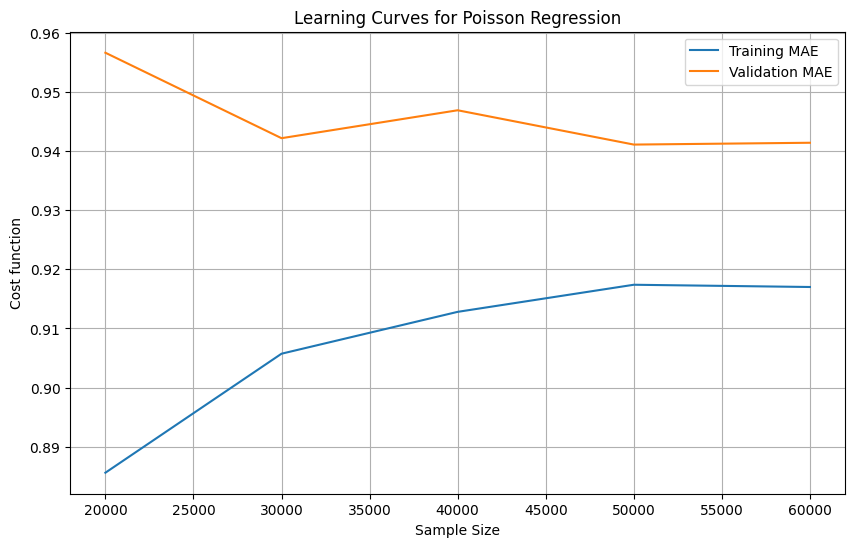

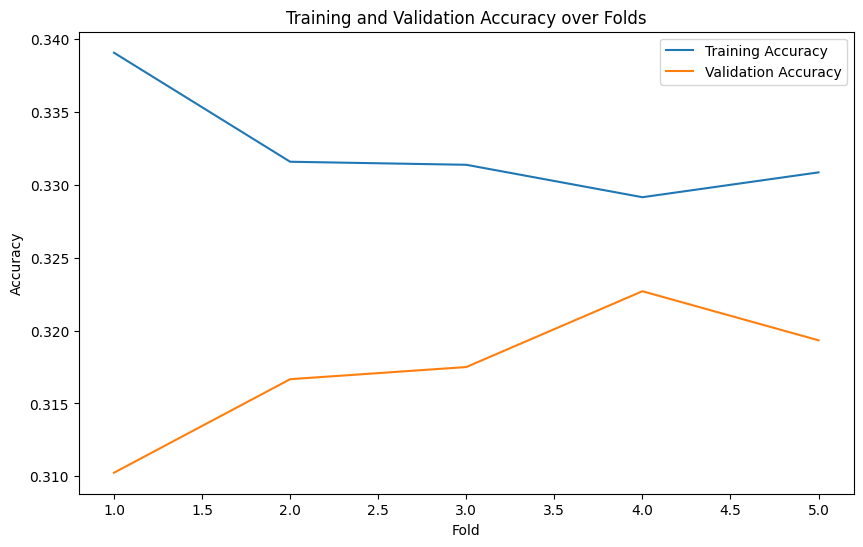

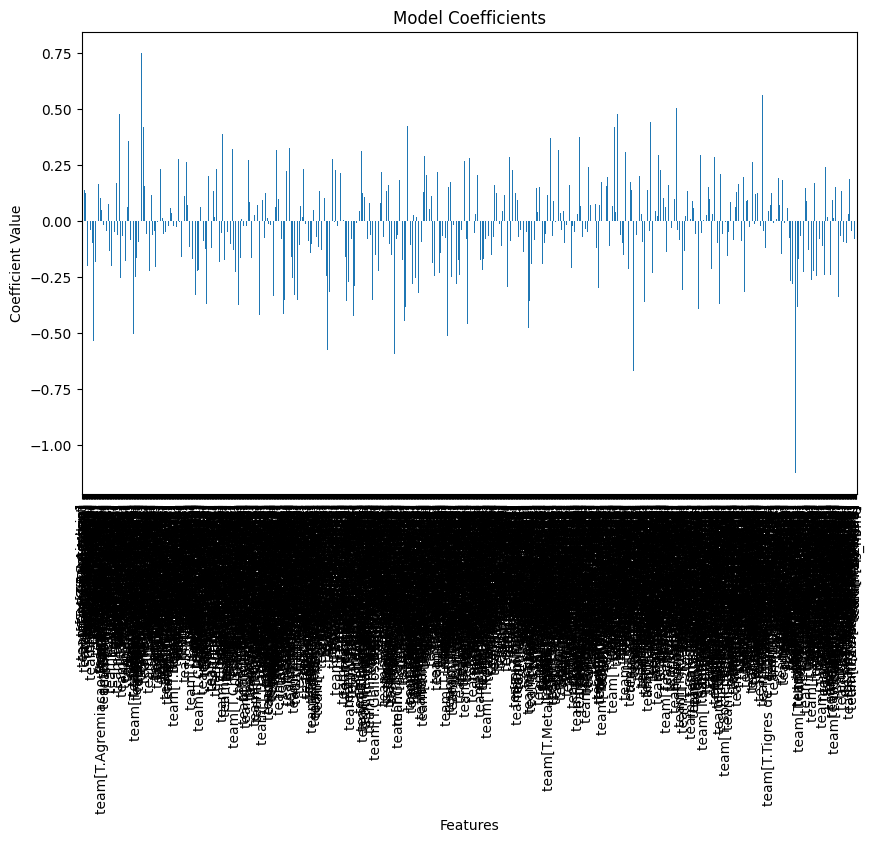

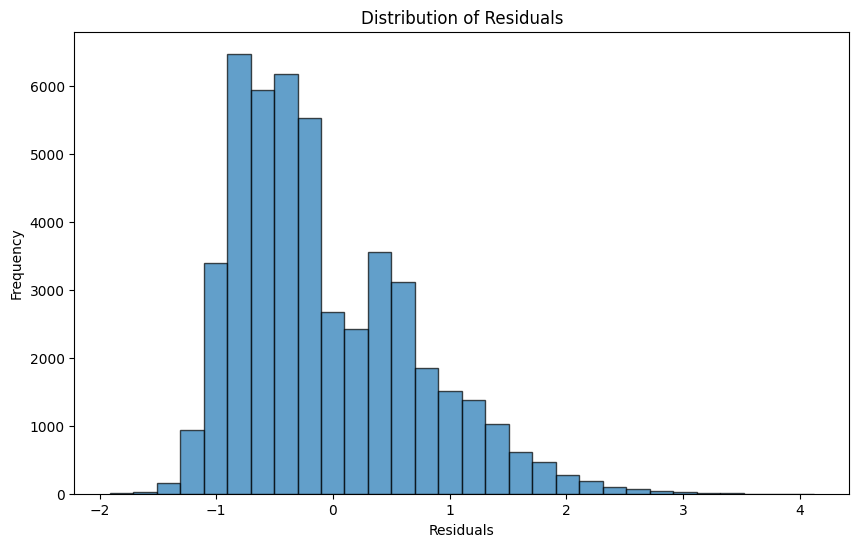

INFO:research_amp.soccer_prediction.models:Poisson model fitted successfully.
INFO:research_amp.soccer_prediction.models:                 Generalized Linear Model Regression Results                  
Dep. Variable:                  goals   No. Observations:                50000
Model:                            GLM   Df Residuals:                    48739
Model Family:                 Poisson   Df Model:                         1260
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -68284.
Date:                Tue, 02 Jul 2024   Deviance:                       29533.
Time:                        15:12:22   Pearson chi2:                 3.33e+04
No. Iterations:                     5   Pseudo R-squ. (CS):            0.06078
Covariance Type:            nonrobust                                         
                                                coef    std err          z      P>|z|    

INFO:research_amp.soccer_prediction.utils:Counts of each type of class prediction: 
predicted_outcome
home_win    20254
away_win     4037
Name: count, dtype: int64
INFO:research_amp.soccer_prediction.utils:Counts of each type of actual outcomes: 
actual_outcome
home_win    10919
away_win     6760
draw         6612
Name: count, dtype: int64


        Date    Sea   Lge                       HT                 AT   HS  \
0 2014-12-20  14-15  ENG5                   Woking          Southport  1.0   
1 2014-02-08  13-14  GER3               Heidenheim       Darmstadt 98  1.0   
2 2015-03-21  14-15  AUS1          Adelaide United  Melbourne Victory  2.0   
3 2012-11-10  12-13  BRA1  Botafogo Rio de Janeiro         Portuguesa  3.0   
4 2010-10-01  10-11  FRA2                    Sedan             Istres  5.0   

    AS  Lambda_HS  Lambda_AS  prob_home_win  prob_away_win  prob_draw  \
0  2.0          2          1       0.570875       0.222782   0.206263   
1  1.0          2          1       0.510828       0.250101   0.239058   
2  2.0          2          1       0.429208       0.334056   0.236724   
3  0.5          2          1       0.432280       0.332883   0.234823   
4  1.0          2          1       0.479567       0.294079   0.226327   

  predicted_outcome actual_outcome  
0          home_win       away_win  
1          home_wi

In [5]:
poisson_model()

In [46]:
# Load predictions dataset.
bucket = "cryptokaizen-data-test"
dataset_path = "kaizen_ai/soccer_prediction/model_output/glm_poisson/"
local_dir = "model_output/glm_poisson"
# Download data from S3.
rasoprut.download_data_from_s3(
    bucket_name=bucket, dataset_path=dataset_path, local_path=local_dir, file_format = ".csv"
)
# Load the data from S3 into pandas dataframe objects.
dataframes = rasoprut.load_data_to_dataframe(local_path=local_dir, file_format = ".csv", sep = ",")
glm_poisson_predictions_df = dataframes["glm_poisson_predictions_df"]


# Dixon-Coles predictions.
def dixon_coles_adjustment(home_goals, away_goals, mu_home, mu_away, rho):
    """
    Apply Dixon-Coles adjustment for low-scoring outcomes.
    
    :param home_goals: Number of goals scored by home team.
    :param away_goals: Number of goals scored by away team.
    :param mu_home: Expected goals for home team.
    :param mu_away: Expected goals for away team.
    :param rho: Dixon-Coles adjustment parameter.
    :return: Adjustment factor.
    """
    # Implement Dixon-Coles adjustment.
    if home_goals <1 and away_goals <1:
        if home_goals == away_goals:
            adjustment = 1 + rho
        elif home_goals != away_goals:
            adjustment = 1 - rho
    else:
        adjustment = 1
    return adjustment


final_df_with_dixon = calculate_match_outcome_and_probabilities(glm_poisson_prediction_df, max_goals=10, apply_dixon_coles=True, rho=0.13)
# Evaluate model.
rasoprut.evaluate_model_predictions(
        final_df_with_dixon["actual_outcome"], final_df_with_dixon["predicted_outcome"]
    )

INFO:research_amp.soccer_prediction.utils:Downloading kaizen_ai/soccer_prediction/model_output/glm_poisson/glm_poisson_predictions.csv to model_output/glm_poisson/glm_poisson_predictions.csv
INFO:research_amp.soccer_prediction.utils:Downloading kaizen_ai/soccer_prediction/model_output/glm_poisson/glm_poisson_predictions_new.csv to model_output/glm_poisson/glm_poisson_predictions_new.csv
INFO:research_amp.soccer_prediction.utils:Data Downloaded.
INFO:research_amp.soccer_prediction.utils:Loading model_output/glm_poisson/glm_poisson_predictions.csv
INFO:research_amp.soccer_prediction.utils: glm_poisson_predictions_df,  (24291, 14)
INFO:research_amp.soccer_prediction.utils:Loading model_output/glm_poisson/glm_poisson_predictions_new.csv
INFO:research_amp.soccer_prediction.utils: glm_poisson_predictions_new_df,  (24291, 14)
INFO:research_amp.soccer_prediction.utils:Data loaded into dataframes.
INFO:research_amp.soccer_prediction.utils:Counts of each type of class prediction: 
predicted_outc

         Date    Sea   Lge                       HT                 AT   HS  \
0  2014-12-20  14-15  ENG5                   Woking          Southport  1.0   
1  2014-02-08  13-14  GER3               Heidenheim       Darmstadt 98  1.0   
2  2015-03-21  14-15  AUS1          Adelaide United  Melbourne Victory  2.0   
3  2012-11-10  12-13  BRA1  Botafogo Rio de Janeiro         Portuguesa  3.0   
4  2010-10-01  10-11  FRA2                    Sedan             Istres  5.0   

    AS  Lambda_HS  Lambda_AS  prob_home_win  prob_away_win  prob_draw  \
0  2.0          2          1       0.605657       0.182585   0.218184   
1  1.0          2          1       0.605657       0.182585   0.218184   
2  2.0          2          1       0.605657       0.182585   0.218184   
3  0.5          2          1       0.605657       0.182585   0.218184   
4  1.0          2          1       0.605657       0.182585   0.218184   

  predicted_outcome actual_outcome  
0          home_win       away_win  
1          h

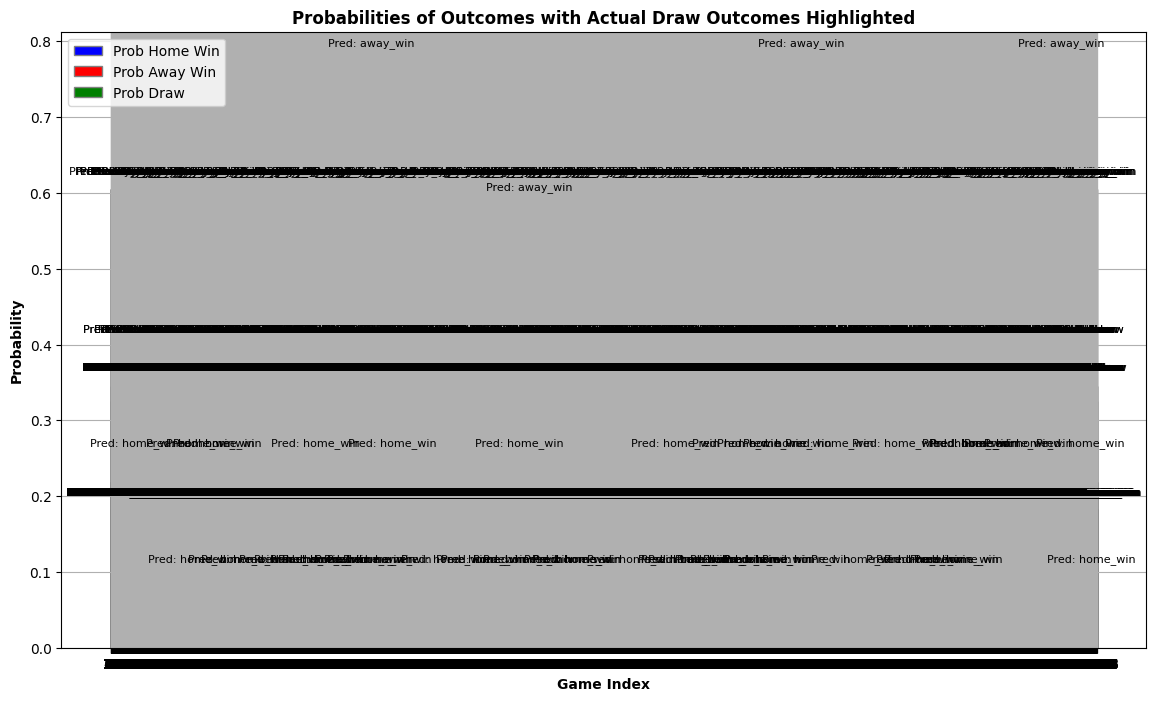

In [14]:
# Filter dataframe to include only rows where the actual outcome is a draw
draw_df = glm_poisson_prediction_df[glm_poisson_prediction_df['actual_outcome'] == 'draw']

# Function to create a bar plot for probabilities with actual draw outcomes
def plot_draw_probabilities(draw_df):
    # Set the positions and width for the bars
    bar_width = 0.25
    r1 = np.arange(len(draw_df))
    r2 = [x + bar_width for x in r1]
    r3 = [x + bar_width for x in r2]

    # Create the bar plot
    fig, ax = plt.subplots(figsize=(14, 8))

    # Bar plots
    ax.bar(r1, draw_df['prob_home_win'], color='blue', width=bar_width, edgecolor='grey', label='Prob Home Win')
    ax.bar(r2, draw_df['prob_away_win'], color='red', width=bar_width, edgecolor='grey', label='Prob Away Win')
    ax.bar(r3, draw_df['prob_draw'], color='green', width=bar_width, edgecolor='grey', label='Prob Draw')

    # Add annotations for predicted outcomes
    for idx, predicted in enumerate(draw_df['predicted_outcome']):
        ax.text(r2[idx], draw_df['prob_away_win'].iloc[idx] + 0.02, f'Pred: {predicted}', ha='center', fontsize=8)

    # Labels and title
    ax.set_xlabel('Game Index', fontweight='bold')
    ax.set_ylabel('Probability', fontweight='bold')
    ax.set_title('Probabilities of Outcomes with Actual Draw Outcomes Highlighted', fontweight='bold')
    ax.set_xticks([r + bar_width for r in range(len(draw_df))])
    ax.set_xticklabels(draw_df.index)
    ax.legend()
    ax.grid(True)

    plt.show()

# Plot the draw probabilities
plot_draw_probabilities(draw_df)

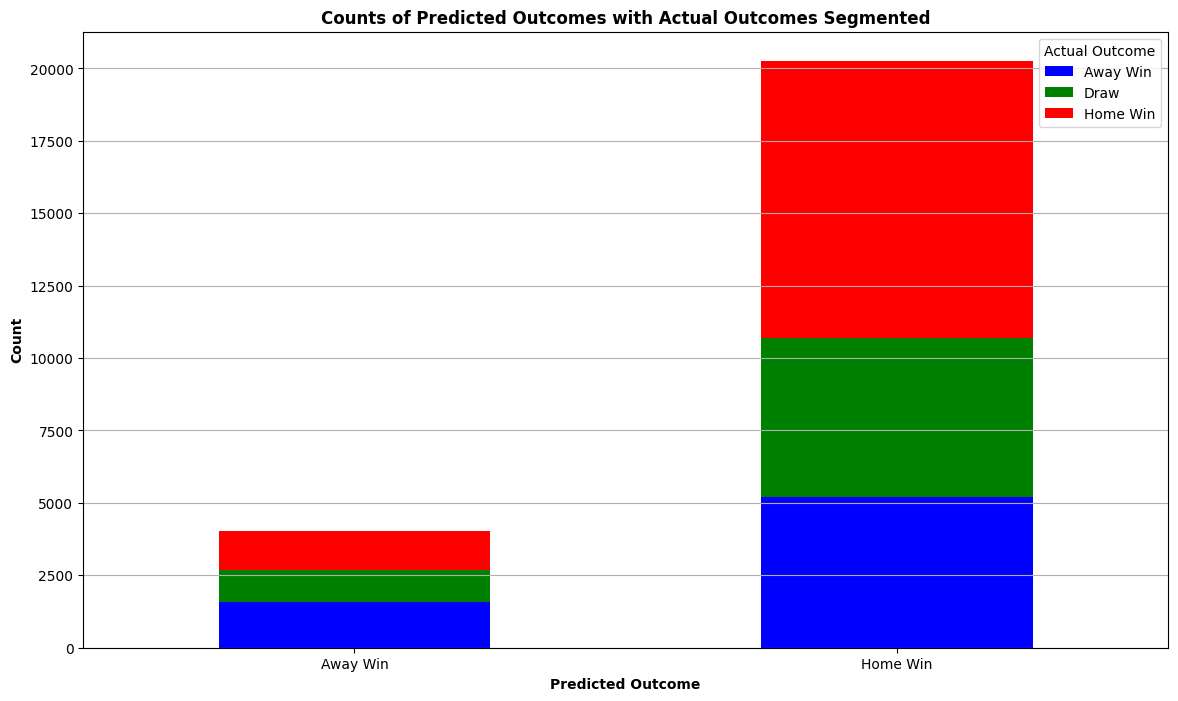

In [47]:
# Mapping outcomes to readable format for visualization purposes
outcome_mapping = {'home_win': 'Home Win', 'away_win': 'Away Win', 'draw': 'Draw'}
glm_poisson_predictions_df['predicted_outcome'] = glm_poisson_predictions_df['predicted_outcome'].map(outcome_mapping)
glm_poisson_predictions_df['actual_outcome'] = glm_poisson_predictions_df['actual_outcome'].map(outcome_mapping)

# Calculate counts only for existing predicted outcomes
counts = glm_poisson_predictions_df.groupby(['predicted_outcome', 'actual_outcome']).size().unstack(fill_value=0)

# Remove columns that don't have any predicted outcomes
counts = counts.loc[(counts.sum(axis=1) != 0), :]

# Convert counts to numeric
counts = counts.astype(int)

# Plotting
ax = counts.plot(kind='bar', stacked=True, figsize=(14, 8), color=['blue', 'green', 'red'])

# Adding labels and title
plt.xlabel('Predicted Outcome', fontweight='bold')
plt.ylabel('Count', fontweight='bold')
plt.title('Counts of Predicted Outcomes with Actual Outcomes Segmented', fontweight='bold')
plt.legend(title='Actual Outcome', loc='upper right')
plt.xticks(rotation=0)
plt.grid(axis='y')

# Show the plot
plt.show()


Probability Stats DataFrame:
                   prob_home_win                               prob_away_win  \
                            min      mean    median       max           min   
predicted_outcome                                                             
Away Win               0.124260  0.329694  0.339461  0.395940      0.334659   
Home Win               0.346772  0.466780  0.456915  0.820526      0.059947   

                                                prob_draw                      \
                       mean    median       max       min      mean    median   
predicted_outcome                                                               
Away Win           0.420641  0.406858  0.704001  0.171535  0.249646  0.248729   
Home Win           0.289925  0.295486  0.396400  0.115681  0.243266  0.244309   

                             
                        max  
predicted_outcome            
Away Win           0.370858  
Home Win           0.359174  
Priors:
 actual_ou

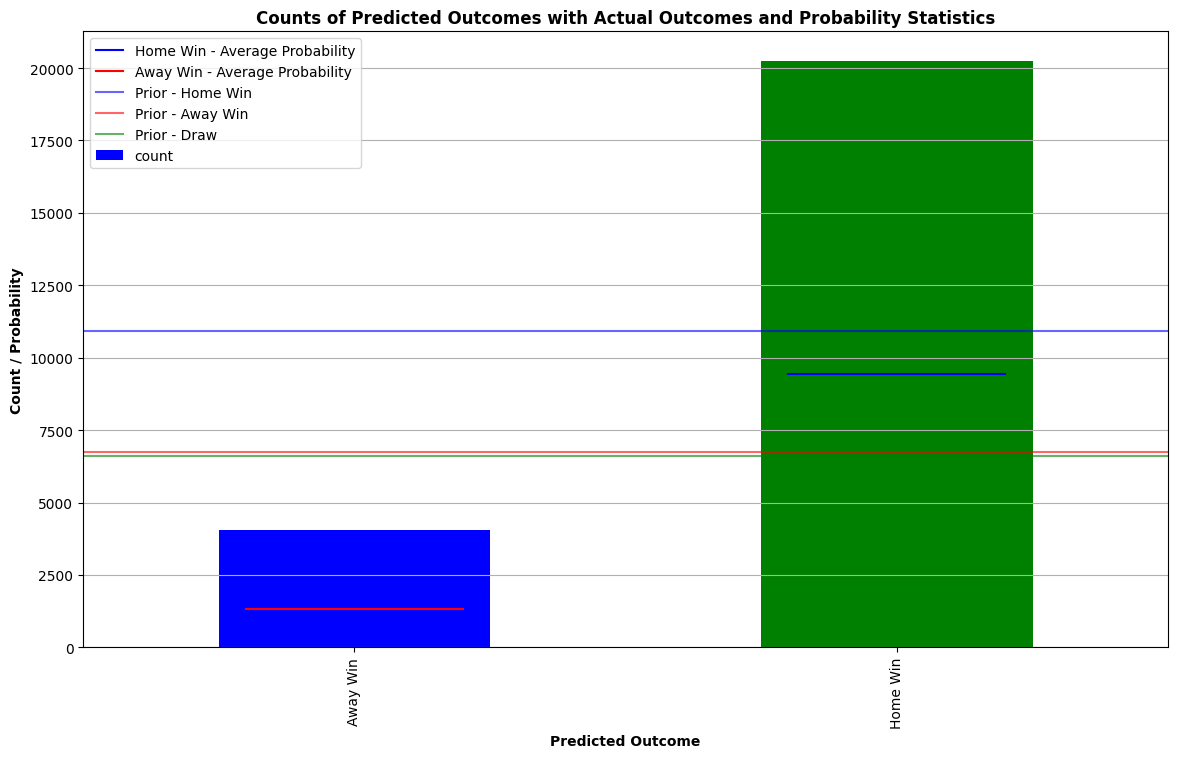

In [53]:
# Compute probability statistics for each predicted class
probability_stats = glm_poisson_predictions_df.groupby('predicted_outcome').agg({
    'prob_home_win': ['min', 'mean', 'median', 'max'],
    'prob_away_win': ['min', 'mean', 'median', 'max'],
    'prob_draw': ['min', 'mean', 'median', 'max']
})

# Print min, median, and max values for reference
print("Probability Stats DataFrame:\n", probability_stats)

# Calculate priors for the actual outcomes
total_count = len(glm_poisson_predictions_df)
actual_counts = glm_poisson_predictions_df['actual_outcome'].value_counts()
priors = actual_counts / total_count

# Print priors for reference
print("Priors:\n", priors)

# Plotting
fig, ax = plt.subplots(figsize=(14, 8))

# Stacked bar plot
counts.plot(kind='bar', stacked=True, color=['blue', 'green', 'red'], ax=ax)

# Plot average probability at appropriate positions
for outcome, color in zip(['Home Win', 'Away Win', 'Draw'], ['blue', 'red', 'green']):
    if outcome in probability_stats.index:
        avg_prob = probability_stats.at[outcome, ('prob_home_win', 'mean')]
        avg_prob_position = counts.loc[outcome].sum() * avg_prob
        pos = [i for i, x in enumerate(counts.index) if x == outcome]
        if pos:
            position = pos[0]
            ax.plot([position - 0.2, position + 0.2], [avg_prob_position, avg_prob_position], linestyle='-', color=color, label=f'{outcome} - Average Probability')

# Plot priors for actual outcomes
for outcome, color in zip(['Home Win', 'Away Win', 'Draw'], ['blue', 'red', 'green']):
    if outcome in priors.index:
        y_prior = priors[outcome] * counts.sum().sum()
        ax.axhline(y_prior, linestyle='-', color=color, label=f'Prior - {outcome}', alpha=0.6)

# Adding labels and title
ax.set_xlabel('Predicted Outcome', fontweight='bold')
ax.set_ylabel('Count / Probability', fontweight='bold')
ax.set_title('Counts of Predicted Outcomes with Actual Outcomes and Probability Statistics', fontweight='bold')
ax.legend(loc='upper left')
ax.set_xticks(range(len(counts.index)))
ax.set_xticklabels(counts.index)
ax.grid(axis='y')

# Show the plot
plt.show()


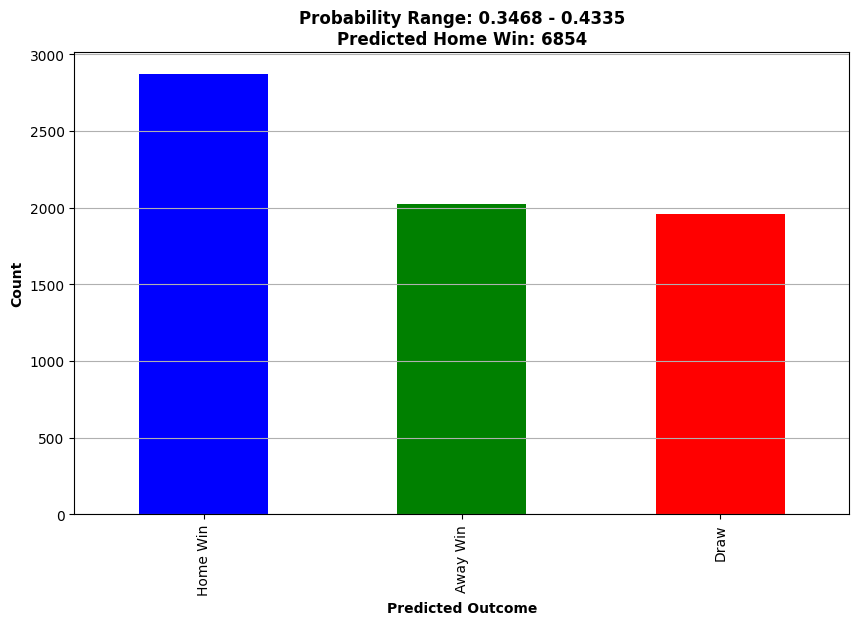

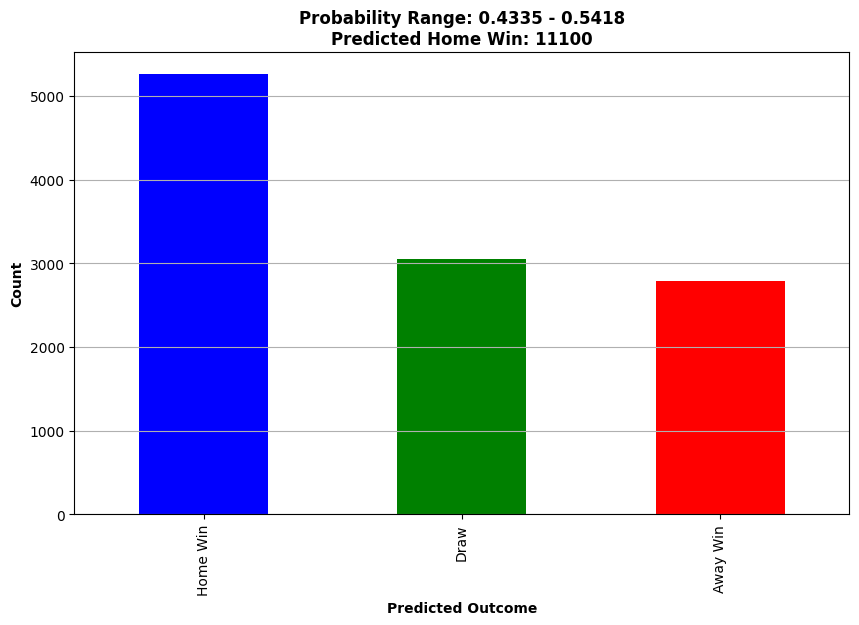

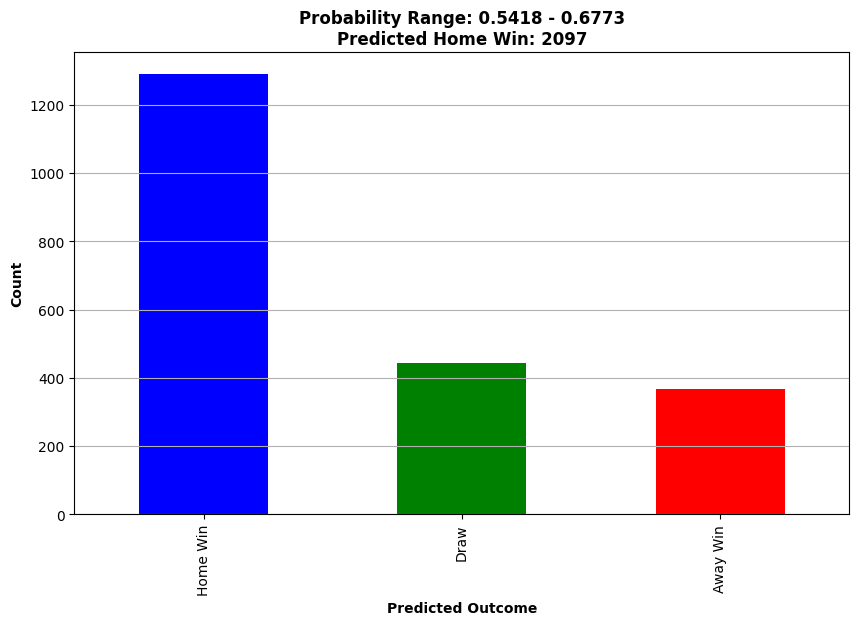

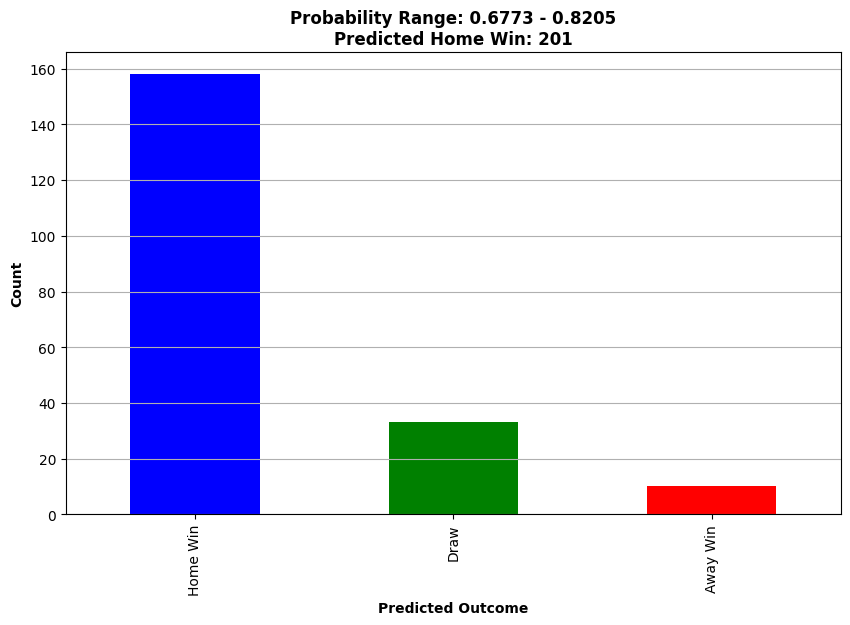

In [64]:
# Function to plot bar graphs for probability ranges
def plot_probability_ranges(data, predicted_class, prob_column):
    df = data[data["predicted_outcome"] == predicted_class]
    min_prob = df[prob_column].min()
    max_prob = df[prob_column].max()
    range_step = 0.25
    ranges = []

    current_min = min_prob
    while current_min < max_prob:
        current_max = min(current_min * (1 + range_step), max_prob)
        ranges.append((current_min, current_max))
        current_min = current_max

    for prob_range in ranges:
        lower, upper = prob_range
        subset = df[(df[prob_column] >= lower) & (df[prob_column] < upper)]
        actual_counts = subset['actual_outcome'].value_counts()

        if not actual_counts.empty:
            fig, ax = plt.subplots(figsize=(10, 6))
            actual_counts.plot(kind='bar', ax=ax, color=['blue', 'green', 'red'])
            
            # Adding labels and title
            ax.set_xlabel('Predicted Outcome', fontweight='bold')
            ax.set_ylabel('Count', fontweight='bold')
            ax.set_title(f'Probability Range: {lower:.4f} - {upper:.4f}\nPredicted {predicted_class}: {len(subset)}', fontweight='bold')
            ax.grid(axis='y')

            plt.show()

# Plot for home wins
plot_probability_ranges(glm_poisson_predictions_df, 'Home Win', 'prob_home_win')
# Plot for home wins
plot_probability_ranges(glm_poisson_predictions_df, 'Away Win', 'prob_a_win')
# Plot for home wins
plot_probability_ranges(glm_poisson_predictions_df, 'Home Win', 'prob_home_win')

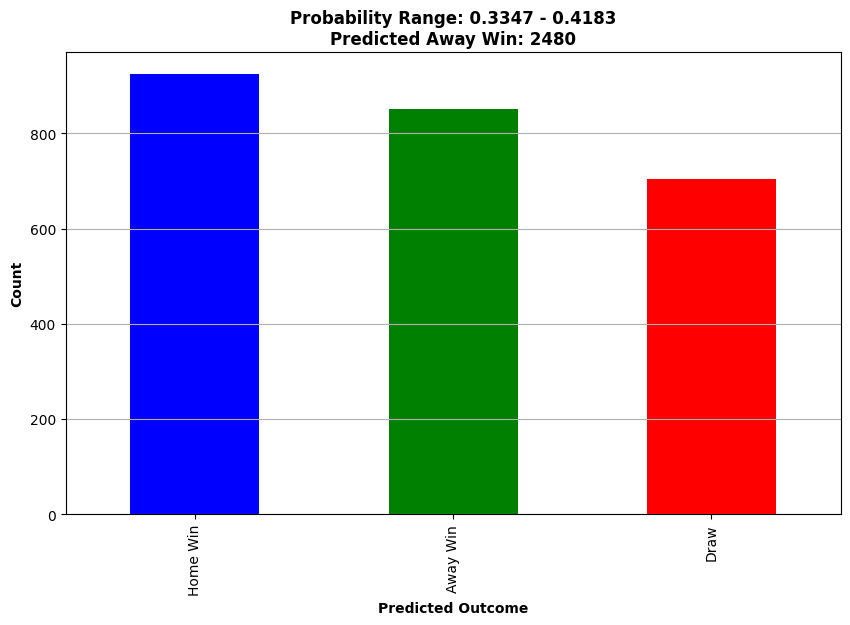

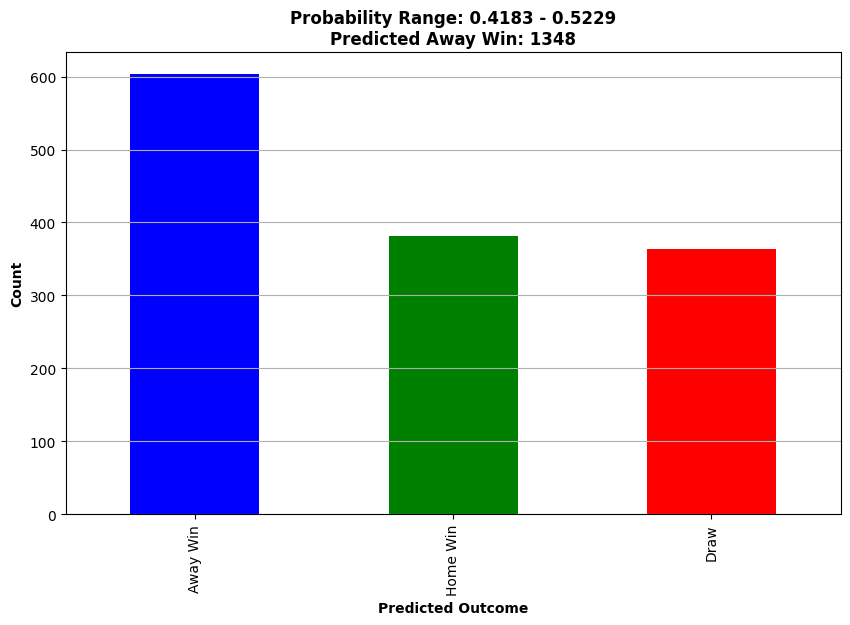

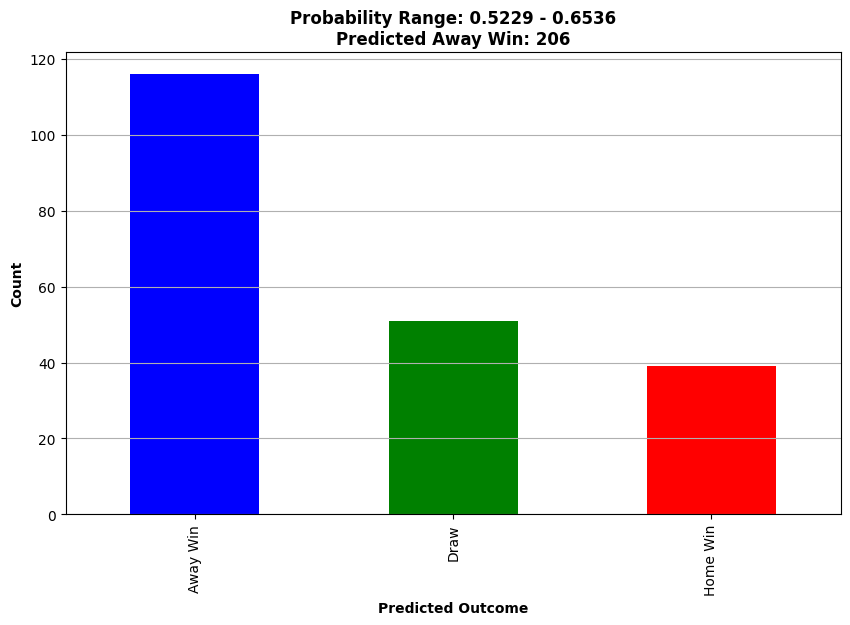

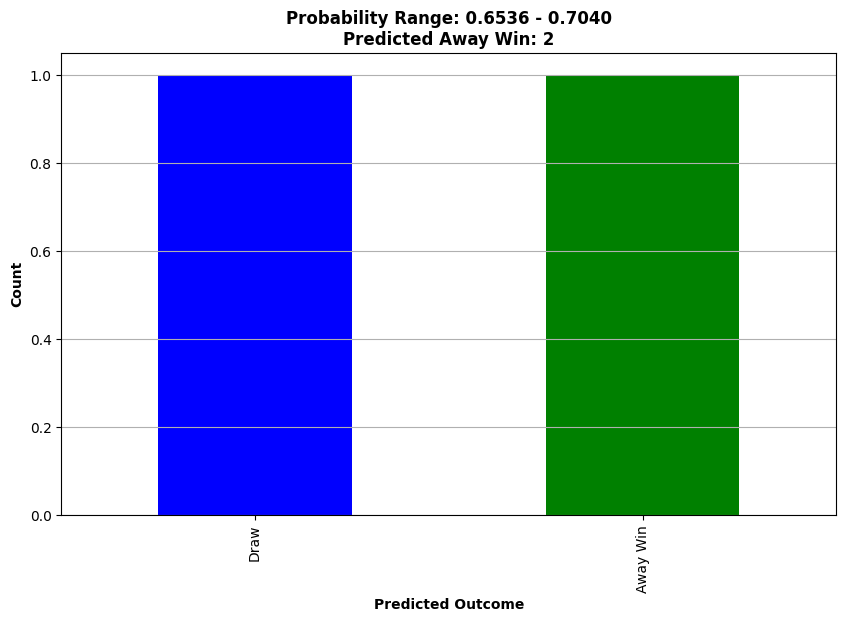

In [66]:
plot_probability_ranges(glm_poisson_predictions_df, 'Away Win', 'prob_away_win')

In [67]:
# Plot for home wins
plot_probability_ranges(glm_poisson_predictions_df, 'Draw', 'prob_draw')